<a href="https://colab.research.google.com/github/creadal/colab-notebooks/blob/main/nickname_generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
with open('nicknames.txt') as f:
  content = f.readlines()
  content = [x.strip() for x in content]

In [ ]:
lengths = [len(x) for x in content]

In [ ]:
import numpy as np

lengths = np.array(lengths)

In [ ]:
x = []
y = []

for i in range(lengths.min(), lengths.max()+1):
  x.append(i)
  y.append(np.sum(lengths == i))

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18],
 [4,
  8,
  97,
  737,
  1443,
  2280,
  2496,
  2021,
  1699,
  1147,
  788,
  620,
  462,
  296,
  258,
  220,
  1,
  1,
  1])

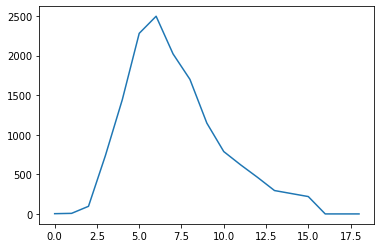

In [ ]:
import matplotlib.pyplot as plt

plt.plot(x, y)
x, y

In [ ]:
for i, e in enumerate(content):
  if len(e) < 2 or len(e) > 15:
    del content[i]

In [ ]:
import torch

X = []
for i, word in enumerate(content):
  sample = []
  for i in range(15):
    if i < len(word):
      sample.append(ord(word[i]))
    else:
      sample.append(0)
  X.append(sample)

indices = []
for i, word in enumerate(X):
  for char in word:
    if char > 128:
      indices.append(i)

indices = list(dict.fromkeys(indices))
for i in indices:
  X.remove(X[i])

X = [x for x in X if max(x) <= 128]

X = torch.Tensor(X)
X.max()

tensor(122.)

In [ ]:
dictionary = {}
Xu = X.unique()
for i in range(len(Xu)):
  dictionary[int(Xu[i])] = i

dictionary

{0: 0,
 32: 1,
 33: 2,
 36: 3,
 39: 4,
 45: 5,
 46: 6,
 48: 7,
 49: 8,
 50: 9,
 51: 10,
 52: 11,
 53: 12,
 54: 13,
 55: 14,
 56: 15,
 57: 16,
 64: 17,
 65: 18,
 66: 19,
 67: 20,
 68: 21,
 69: 22,
 70: 23,
 71: 24,
 72: 25,
 73: 26,
 74: 27,
 75: 28,
 76: 29,
 77: 30,
 78: 31,
 79: 32,
 80: 33,
 81: 34,
 82: 35,
 83: 36,
 84: 37,
 85: 38,
 86: 39,
 87: 40,
 88: 41,
 89: 42,
 90: 43,
 91: 44,
 93: 45,
 94: 46,
 95: 47,
 96: 48,
 97: 49,
 98: 50,
 99: 51,
 100: 52,
 101: 53,
 102: 54,
 103: 55,
 104: 56,
 105: 57,
 106: 58,
 107: 59,
 108: 60,
 109: 61,
 110: 62,
 111: 63,
 112: 64,
 113: 65,
 114: 66,
 115: 67,
 116: 68,
 117: 69,
 118: 70,
 119: 71,
 120: 72,
 121: 73,
 122: 74}

In [ ]:
new_X = []
for row in X:
  new_row = []
  for e in row:
    new_row.append(dictionary[int(e)])
  new_X.append(new_row)

X = torch.Tensor(new_X)

In [ ]:
int(list(dictionary.keys())[40])

87

In [ ]:
import torch.nn as nn

encoder = nn.Sequential(
    nn.Conv1d(1, 8, 10),
    nn.ReLU(),
    nn.Conv1d(8, 16, 6),
    nn.ReLU(),
    nn.ConvTranspose1d(16, 32, 1)
)

decoder = nn.Sequential(
    nn.ConvTranspose1d(32, 16, 6),
    nn.ReLU(),
    nn.ConvTranspose1d(16, 8, 10),
    nn.ReLU(),
    nn.ConvTranspose1d(8, 1, 1)
)

In [ ]:
X = X.unsqueeze(1)

In [ ]:
output = encoder(X)
print(output.shape)
output = decoder(output)
output.shape

torch.Size([14521, 32, 1])


torch.Size([14521, 1, 15])

In [ ]:
from sklearn.model_selection import train_test_split

X, X_val = train_test_split(X, test_size=0.1)

In [ ]:
dataloader = torch.utils.data.DataLoader(X, 
                            batch_size=8, 
                            shuffle=True, 
                            num_workers=4
                            )
valoader = torch.utils.data.DataLoader(X_val, 
                            batch_size=8, 
                            shuffle=True, 
                            num_workers=4
                            )

loaders = {'train': dataloader, 'val': valoader}

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
loss_function = nn.MSELoss()

params = list(encoder.parameters()) + list(decoder.parameters())
optimizer = torch.optim.Adam(params, lr=1e-4)

In [ ]:
train_losses = []
val_losses = []

In [ ]:
from tqdm.notebook import tqdm

# Run the training loop
for epoch in range(0, 36): # 5 epochs at maximum
  
  for phase in ('train', 'val'):

    # Print epoch
    print(f'Starting epoch {epoch+1}')
      
    # Set current loss value
    current_loss = 0.0
    count = 0
      
    # Iterate over the DataLoader for training data
    for sample in tqdm(loaders[phase], desc=phase):
        optimizer.zero_grad()

        outputs = encoder(sample)
        outputs = decoder(outputs)

        loss = loss_function(outputs, sample)
        
        if phase == 'train':
          loss.backward()
          optimizer.step()
        
        current_loss += loss.item()
        count += 1

    current_loss /= count
    print(f'{phase} loss: {current_loss}')

    if phase == 'train':
      train_losses.append(current_loss)
    else:
      val_losses.append(current_loss)

    current_loss = 0.0
    count = 0

  # Process is complete.
  print('Training process has finished.')

Starting epoch 1


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))



train loss: 348.55005934072096
Starting epoch 1



val loss: 148.1492736313369
Training process has finished.
Starting epoch 2



train loss: 123.6900389891943
Starting epoch 2



val loss: 105.716398197216
Training process has finished.
Starting epoch 3



train loss: 84.6857002939997
Starting epoch 3



val loss: 73.7791986151056
Training process has finished.
Starting epoch 4



train loss: 63.83598548545977
Starting epoch 4



val loss: 62.15882934318794
Training process has finished.
Starting epoch 5



train loss: 54.297811833268426
Starting epoch 5



val loss: 51.373452427623036
Training process has finished.
Starting epoch 6



train loss: 44.031192938292186
Starting epoch 6



val loss: 41.3376678110479
Training process has finished.
Starting epoch 7



train loss: 36.84892793121945
Starting epoch 7



val loss: 34.39594444337782
Training process has finished.
Starting epoch 8



train loss: 29.466220373477025
Starting epoch 8



val loss: 25.631096017229687
Training process has finished.
Starting epoch 9



train loss: 20.355882962447485
Starting epoch 9



val loss: 16.93471470114949
Training process has finished.
Starting epoch 10



train loss: 12.695575111207063
Starting epoch 10



val loss: 10.929526219656179
Training process has finished.
Starting epoch 11



train loss: 8.605421213398948
Starting epoch 11



val loss: 8.551081258353296
Training process has finished.
Starting epoch 12



train loss: 6.8124184292653345
Starting epoch 12



val loss: 7.08784157365233
Training process has finished.
Starting epoch 13



train loss: 5.788918097087409
Starting epoch 13



val loss: 6.257576946046326
Training process has finished.
Starting epoch 14



train loss: 5.032780006687491
Starting epoch 14



val loss: 5.804535635634438
Training process has finished.
Starting epoch 15



train loss: 4.576266812345279
Starting epoch 15



val loss: 5.368633225764874
Training process has finished.
Starting epoch 16



train loss: 4.294484913554339
Starting epoch 16



val loss: 4.761015926743601
Training process has finished.
Starting epoch 17



train loss: 4.0752249132554565
Starting epoch 17



val loss: 4.765501334935754
Training process has finished.
Starting epoch 18



train loss: 3.8670406206927037
Starting epoch 18



val loss: 4.474673342942209
Training process has finished.
Starting epoch 19



train loss: 3.680081392997463
Starting epoch 19



val loss: 4.234916939021467
Training process has finished.
Starting epoch 20



train loss: 3.5354760929695908
Starting epoch 20



val loss: 4.229985148001176
Training process has finished.
Starting epoch 21



train loss: 3.383676510445564
Starting epoch 21



val loss: 3.84268360216539
Training process has finished.
Starting epoch 22



train loss: 3.2286858749365024
Starting epoch 22



val loss: 3.781794709654955
Training process has finished.
Starting epoch 23



train loss: 3.0725516207776096
Starting epoch 23



val loss: 3.4886130753822706
Training process has finished.
Starting epoch 24



train loss: 2.89901035677441
Starting epoch 24



val loss: 3.357190600913632
Training process has finished.
Starting epoch 25



train loss: 2.73794242584875
Starting epoch 25



val loss: 3.097171057199875
Training process has finished.
Starting epoch 26



train loss: 2.5564743140188013
Starting epoch 26



val loss: 3.029893547173712
Training process has finished.
Starting epoch 27



train loss: 2.342719105806434
Starting epoch 27



val loss: 2.7564827482942698
Training process has finished.
Starting epoch 28



train loss: 2.175649978236422
Starting epoch 28



val loss: 2.41273893608333
Training process has finished.
Starting epoch 29



train loss: 1.9930530248535854
Starting epoch 29



val loss: 2.1522523492656567
Training process has finished.
Starting epoch 30



train loss: 1.8411796240072191
Starting epoch 30



val loss: 1.9393057649607186
Training process has finished.
Starting epoch 31



train loss: 1.677010863189525
Starting epoch 31



val loss: 1.7556476514929762
Training process has finished.
Starting epoch 32



train loss: 1.5264402359673888
Starting epoch 32



val loss: 1.6554760843065086
Training process has finished.
Starting epoch 33



train loss: 1.4317290600015344
Starting epoch 33



val loss: 1.5493778319476725
Training process has finished.
Starting epoch 34



train loss: 1.2737291767039636
Starting epoch 34



val loss: 1.3290048203031932
Training process has finished.
Starting epoch 35



train loss: 1.1623356985464017
Starting epoch 35



val loss: 1.2822620590309521
Training process has finished.
Starting epoch 36



train loss: 1.0805333923808365
Starting epoch 36



val loss: 1.360698064236523
Training process has finished.


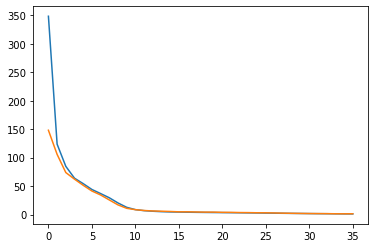

In [ ]:
plt.plot(np.arange(len(train_losses)), train_losses)
plt.plot(np.arange(len(val_losses)), val_losses)
plt.show()train

In [ ]:
sample = next(iter(dataloader))

output = encoder(sample)
output = decoder(output)

''.join([chr(decoding_dictionary[round(float(x))]) for x in output[0][0] if x > 1 and x < 75]), ''.join([chr(decoding_dictionary[int(x)]) for x in sample[0][0] if x > 0 and x < 75])

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


('grimacee', 'grimacee')

In [ ]:
decoding_dictionary = {value: key for key, value in dictionary.items()}

In [ ]:
anloader = torch.utils.data.DataLoader(X, 
                            batch_size=1, 
                            shuffle=True, 
                            num_workers=4
                            )

features = []
for i in range(32):
  features.append([])

for sample in anloader:
  output = encoder(sample)
  for i, e in enumerate(output[0]):
    features[i].append(float(e))

features = np.array(features)
features.shape

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


(32, 13068)

In [ ]:
mean_vector = []
for i, feature in enumerate(features):
  print('No.%i: Min: %.2f, Max: %.2f, Mean: %.2f' % (i+1, feature.min(), feature.max(), feature.mean()))
  mean_vector.append(feature.mean())

No.1: Min: -36.41, Max: 41.65, Mean: 18.18
No.2: Min: -60.26, Max: 10.86, Mean: -29.31
No.3: Min: -33.02, Max: 86.63, Mean: -8.70
No.4: Min: -99.84, Max: -0.62, Mean: -31.09
No.5: Min: -61.20, Max: 40.18, Mean: -22.34
No.6: Min: -84.99, Max: 23.55, Mean: -10.11
No.7: Min: -56.41, Max: 8.98, Mean: -31.22
No.8: Min: -141.41, Max: 10.73, Mean: -11.16
No.9: Min: 1.73, Max: 158.30, Mean: 64.90
No.10: Min: -72.78, Max: -1.60, Mean: -33.25
No.11: Min: -7.18, Max: 87.92, Mean: 27.53
No.12: Min: 2.22, Max: 81.61, Mean: 42.64
No.13: Min: -31.08, Max: 27.41, Mean: -9.39
No.14: Min: -60.55, Max: 18.41, Mean: -8.77
No.15: Min: 1.01, Max: 101.58, Mean: 34.88
No.16: Min: -127.77, Max: -1.88, Mean: -65.22
No.17: Min: -41.61, Max: 35.56, Mean: 0.15
No.18: Min: -125.80, Max: -0.99, Mean: -44.48
No.19: Min: -23.73, Max: 28.60, Mean: -3.84
No.20: Min: -76.23, Max: 38.95, Mean: -36.92
No.21: Min: -29.29, Max: 69.48, Mean: -10.23
No.22: Min: -92.13, Max: 8.21, Mean: -19.19
No.23: Min: -22.59, Max: 45.12, Me

In [ ]:
mean_vector = torch.Tensor(mean_vector)

In [ ]:
whitecat = encoder(X[0].unsqueeze(1))
whitecat = whitecat.squeeze()

In [ ]:
vowels = 'aeyuioAEYUIO'
cons = 'qwrtpsdfghjklzxcvbnmQWRTPSDFGHJKLZXCVBNM'

def isNickname(word):
  v = 0
  c = 0
  s = 0
  for ch in word:
    if ch in vowels:
      v+=1
      c=0
      s=0
    elif ch in cons:
      v=0
      s=0
      c+=1
    else:
      v=0
      c=0
      s+=1
    
    if v > 2 or c > 2 or s > 2:
      return False
  return True

In [ ]:
for i in range(0, 120):
  a = torch.cat((whitecat[:28], torch.Tensor([i]), whitecat[29:]))
  a = a.unsqueeze(1).unsqueeze(0)
  output = decoder(a)
  str1 = ''.join([chr(decoding_dictionary[round(float(x))]) for x in output[0][0] if x > 1 and x < 74])
  print(str1)

kiqjmZ!-
kirjmZ!-
kirkm[!-
kirkm[!'
kirll[!'
kirzll[!'
kirzll]!'
kiryml]!'
kiryml]!'
kirynk^!'
lisxnk^!$
lisxok^ $
lisxok^ $
liswok^ $
liswpj_ $
liswpj_ !
lisvqj_!
lisvqj_!
lisvrj_!
lisurj`!
lituri`!
mitusi` 
mittsi` 
mitttia 
mitttia
mitstha
mitsuha
mitsuha
mitrvhb
mitrvhb
miurwgb 
miuqwgb!
miuqwgc!
niuqxgc!
niuqxgc$
niupyfc$
niupyfc$
niupzfd'
niuozfd'
niuofd'
niuofd-
niuoed-
niuoee-
niuoee-
oiunee. 
oiunee. 
oiunee. 
oiunef0 
oiundf0 
oiundf 0 
oiumdf 0 
oiumdf 0 
oiumdg 1 
oiumdg 1 
oivmcg!1!
pivmcg!1!
pivlcg!2!
pivlcg!2!
pivlch!2!
pivlch!2!
pivlbh!2 !
pivlbh!3 !
pivkbh!3 !
pivkbi!3 !
pivkbi$3 !
pivkbi$3 !
pivkai$4 !
qivkai$4 !
qivjaj$4!!
qivjaj$4!!
qivjaj$4!!
qivjaj$5!!
qivjaj$5!!
qivi`k'5!$
qivi`k'5!$
qivi`k'5!$
qivi`k'6!$
qivi`k'6!$
rivi`l'6!$
rjvh_l-6!$
rjvh_l-6!$
rjvh_l-7!$
rjvh_l-7!$
rjvh_l.7$$
rjvg_m.7$$
rjvg_m.7$$
rjvg^m.7$$
rjvg^m.8$$
rjvg^m08$$
rjvf^n08$$
sjvf^n08$$
sjvf^n08$$
sjvf^n09$$
sjvf]n19$'
sjvf]o19$'
sjve]o19$'
sjve]o19$'
sjve]o2@$'
sjve]o2@''
sjve[p2@''
sjve[p2@'

In [ ]:
name = 'Danju'
name_coded = []

for i in range(15):
  if i < len(name):
    name_coded.append(ord(name[i]))
  else:
    name_coded.append(0)

for i in range(15):
  name_coded[i] = dictionary[name_coded[i]]

name_coded = torch.Tensor(name_coded).unsqueeze(0).unsqueeze(0)

In [ ]:
output = encoder(name_coded)
output

tensor([[[ 20.8998],
         [-27.6699],
         [-21.8373],
         [-19.2515],
         [-26.0579],
         [-12.1436],
         [-29.7896],
         [ -6.9411],
         [ 47.7919],
         [-34.5625],
         [ 13.5246],
         [ 39.4813],
         [-13.7611],
         [ -4.7399],
         [ 14.9539],
         [-51.6473],
         [ -4.5535],
         [-31.2199],
         [  3.3326],
         [-30.0708],
         [-14.8888],
         [-10.6324],
         [ -6.1837],
         [ 27.9491],
         [ 13.7929],
         [  1.6221],
         [ 12.5017],
         [-17.4617],
         [ 18.7105],
         [-41.0220],
         [ 48.2876],
         [ 23.0137]]], grad_fn=<SqueezeBackward1>)

In [ ]:
output = decoder(output)
str1 = ''.join([chr(decoding_dictionary[round(float(x))]) for x in output[0][0] if x > 1 and x < 74])
str1

'Danju'